In [44]:
# build graph as nested dictionary

# f = open("FB15K_EntityTriples.txt", "r")
# lines = f.readlines()

# d = {}

# for line in lines[:10000]:
#     entity1, relation, entity2, _, = line.split()
#     relation = relation.replace("/", ", ")[2:]
#     if entity1 not in d:
#         d[entity1] = {}
#     d[entity1][entity2] = relation

# import json
# json.dump(d, open("", "w"))

In [76]:
# random walk through knowledge graph to generate 5000 "sentences"

# import json
# d = json.load(open("fb15k_dict.json"))

# import random
# keys = list(d.keys())
# chosen_keys = random.sample(keys, 5000)

# sentences = []

# for key in chosen_keys:
#     current_sentence = [key]
#     for i in range(4):
#         if key not in d:
#             break
#         next_key_candidates = list(d[key].keys())
#         next_key = random.choice(next_key_candidates)
#         relation = d[key][next_key]
#         current_sentence.append(relation)
#         current_sentence.append(next_key)
#         key = next_key
#     if len(current_sentence) != 9:
#         continue
#     sentences.append(current_sentence)

# import json
# json.dump(sentences, open("sentences.json", "w"))

In [ ]:
# load image urls into dictionary (util)

# f = open("URLS_google.txt")
# lines = f.readlines()

# import urllib
# from PIL import Image

# d = {}

# i = 0
# for line in lines[:]:
#     print(i)
#     i += 1
#     obj = line.replace("\n", "").split("\t")
#     entity = "/" + obj[1].split("/")[0].replace(".", "/")
#     if entity in d:
#         if len(list(d[entity])) >= 20:
#             continue
#     if entity not in d:
#         d[entity] = []
#     d[entity].append(obj[0])

# import json
# json.dump(d, open("urls_dict.json", "w"))

In [132]:
# load sentences and urls

import json

sentences = json.load(open("sentences.json", "r"))
urls = json.load(open("urls_dict.json", "r"))

In [ ]:
# # Downloading Images (from entities in first 200 sentences)

# import urllib

# visited = set()

# def fetch_image(entity, urls):
#     if entity not in urls:
#         return
#     if entity in visited:
#         return
        
#     for url in urls[entity]:
#         try:
#             urllib.request.urlretrieve(url, "./images/" + entity[3:] + ".png")
#             print("yeah")
#             visited.add(entity)
#             return
#         except:
#             print("failed")
#             continue

# i = 0
# for sentence in sentences[100:200]:
#     print(i)
#     i += 1
#     ims = [fetch_image(sentence[i], urls) for i in range(0, len(sentence), 2)]

In [134]:
# # Filter out good sentences (for which we were able to get all images)

# import glob
# ims_downloaded = [name[7:-4]for name in glob.glob("images/*")]
# print(len(ims_downloaded))

# good_sentences = []

# for sentence in sentences:
#     ims = [sentence[i] for i in range(0, len(sentence), 2)]
#     bad = False
#     for im in ims:
#         if im[3:] not in ims_downloaded:
#             bad = True
#     if not bad:
#         good_sentences.append(sentence)

837


In [ ]:
# # generate embeddings for good sentences

# from PIL import Image
# import requests
# import torch
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# from transformers import CLIPProcessor, CLIPModel

# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# def fetch_image(entity):
#     im = Image.open("images/" + entity[3:] + ".png")
#     return im

# final_out = []
            
# for sentence in good_sentences[3:]:
#     try:
#         curr = []
#         print(sentence)
    
#         ims = [fetch_image(sentence[i]) for i in range(0, len(sentence), 2)]
#         text = [sentence[i] for i in range(1, len(sentence), 2)]

#         print(ims[0])
    
#         inputs = processor(text=text, images=ims, return_tensors="pt", padding=True)
#         outputs = model(**inputs)
#         im_embeds = outputs.image_embeds.squeeze()
#         text_embeds = outputs.text_embeds.squeeze()
    
#         out = torch.zeros(im_embeds.shape[0] + text_embeds.shape[0], im_embeds.shape[1])
#         for i in range(text_embeds.shape[0]):
#             out[i] = im_embeds[i]
#             out[i+1] = text_embeds[i]
#         out[-1] = im_embeds[-1]
#         print(out.shape)
#         final_out.append(out.unsqueeze(0))
#     except:
#         print("failed")
#         continue

# final_out = torch.concat(final_out, axis=0)
# torch.save(final_out, "sentence_embeddings.torch")

In [2]:
import torch
emb = torch.load("sentence_embeddings.torch")

In [3]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [4]:
def mask_batch(x):
    # x shape - [batch, 9, 512]
    out = torch.clone(x)
    b = x.shape[0]
    s = x.shape[1]
    idxs = torch.randint(low=0, high=s, size=(1,b)).squeeze()
    for i, idx in enumerate(idxs):
        out[i, idx] = torch.zeros(512)
    return idxs[0], out

In [9]:
t = nn.Sequential(
    nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=512, nhead=8), num_layers=6),
    nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=512, nhead=8), num_layers=6),
    nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=512, nhead=8), num_layers=6),
)

emb = emb[:140]

def train(t, emb, epochs=100, batch_size=20, lr=1e-4):
    t.train()
    
    ds = torch.utils.data.TensorDataset(emb)
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
    
    p = PositionalEncoding(512, max_len=9)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(t.parameters(), lr=lr)

    losses = []
    accs = []
    
    for epoch in range(epochs):
        print("Epoch: ", epoch)
        local_loss = []
        local_acc = []
        for i, batch in enumerate(dl):

            batch = batch[0]
            
            idx, masked_batch = mask_batch(batch)
            batch = p(batch)
            masked_batch = p(masked_batch)

            optimizer.zero_grad()
            
            pred = t(masked_batch)
            loss = loss_fn(pred, batch)
            
            loss.backward()
            optimizer.step()

            #print(i, loss.item())
            test_dist = nn.functional.l1_loss(pred[idx], batch[idx])

            local_loss.append(loss.item())
            local_acc.append(test_dist.item())
        losses.append(sum(local_loss) / len(local_loss))
        accs.append(sum(local_acc) / len(local_acc))

    return losses, accs

In [10]:
losses, accs = train(t, emb)

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89
Epoch:  90
Epoch:  9

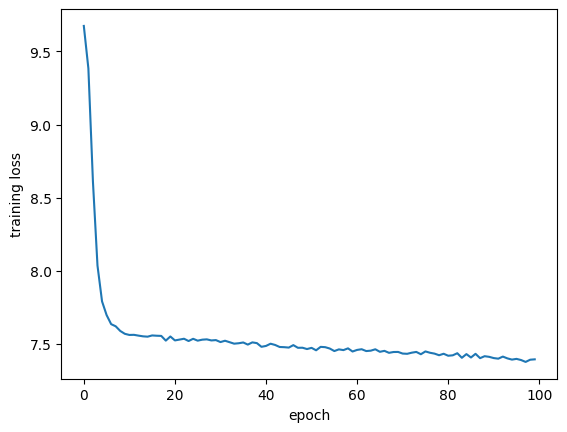

In [12]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.savefig("train_loss.png")

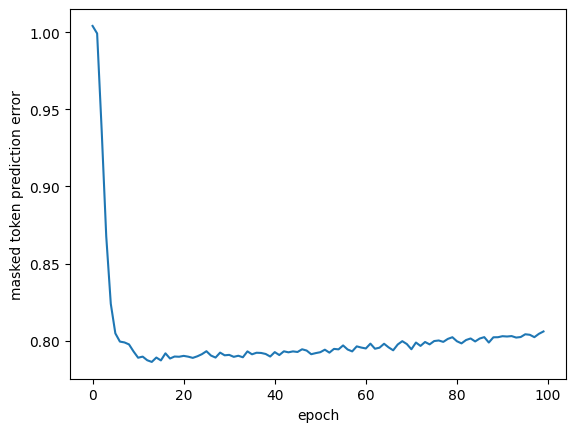

In [14]:
import matplotlib.pyplot as plt

plt.plot(accs)
plt.xlabel("epoch")
plt.ylabel("masked token prediction error")
plt.savefig("acc.png")